# Aalen加法ハザード回帰モデル

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
from lifelines import AalenAdditiveFitter
from lifelines.datasets import load_dd

data = load_dd()
data.head()

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
0,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1946.1952.Mona...,Non-democracy,Monarchy,1946,7,1
1,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1953.1962.Ci...,Non-democracy,Civilian Dict,1953,10,1
2,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1963.1972.Mona...,Non-democracy,Monarchy,1963,10,1
3,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1973.1977.Ci...,Non-democracy,Civilian Dict,1973,5,0
4,Afghanistan,700,700.0,Southern Asia,Asia,Nur Mohammad Taraki,Nur Mohammad Taraki.Afghanistan.1978.1978.Civi...,Non-democracy,Civilian Dict,1978,1,0


In [41]:
import patsy
X = patsy.dmatrix('un_continent_name + regime + start_year', data, return_type='dataframe')
X = X.rename(columns={'Intercept': 'baseline'})
X.columns.tolist()

['baseline',
 'un_continent_name[T.Americas]',
 'un_continent_name[T.Asia]',
 'un_continent_name[T.Europe]',
 'un_continent_name[T.Oceania]',
 'regime[T.Military Dict]',
 'regime[T.Mixed Dem]',
 'regime[T.Monarchy]',
 'regime[T.Parliamentary Dem]',
 'regime[T.Presidential Dem]',
 'start_year']

In [67]:
X['T'] = data['duration']
X['E'] = data['observed']


aaf = AalenAdditiveFitter(coef_penalizer=10)
aaf.fit(X, 'T', event_col='E')
aaf.cumulative_hazards_.head()

 [-----------------100%-----------------] 1468 of 1468 complete in 1.6 sec


,baseline,un_continent_name[T.Americas],un_continent_name[T.Asia],un_continent_name[T.Europe],un_continent_name[T.Oceania],regime[T.Military Dict],regime[T.Mixed Dem],regime[T.Monarchy],regime[T.Parliamentary Dem],regime[T.Presidential Dem],start_year
1,-0.062017,-0.031644,0.061877,0.205616,-0.009814,0.075820,0.086867,-0.134915,0.048669,0.128025,0.000107
2,0.262498,-0.025388,0.110506,0.208022,-0.078462,0.116100,0.361938,-0.228139,0.170570,0.123716,-0.000016
3,0.557500,-0.072982,0.108153,0.161179,0.062917,0.163589,0.684788,-0.273251,0.332028,0.149704,-0.000125
4,0.704063,0.066850,0.149465,0.259783,0.183470,0.223636,0.945805,-0.296419,0.372030,0.429708,-0.000194
5,0.677894,0.200740,0.209847,0.242562,0.187033,0.246778,1.143002,-0.392495,0.546228,0.755278,-0.000155


/Users/taiyou/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['[IPAexGothic]'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


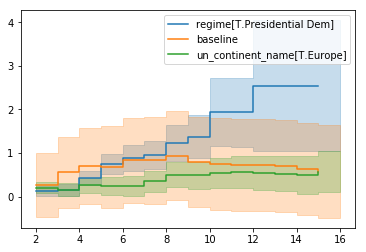

In [68]:
aaf.plot(columns=['regime[T.Presidential Dem]', 'baseline', 'un_continent_name[T.Europe]'], iloc=slice(1,15))

In [64]:
ix = (data['ctryname'] == 'Canada') & (data['start_year'] == 2006)
harper = X.loc[ix]
print("Harper's unique data point:")
harper

Harper's unique data point:


,baseline,un_continent_name[T.Americas],un_continent_name[T.Asia],un_continent_name[T.Europe],un_continent_name[T.Oceania],regime[T.Military Dict],regime[T.Mixed Dem],regime[T.Monarchy],regime[T.Parliamentary Dem],regime[T.Presidential Dem],start_year,T,E
268,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2006.0,3,0


/Users/taiyou/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['[IPAexGothic]'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


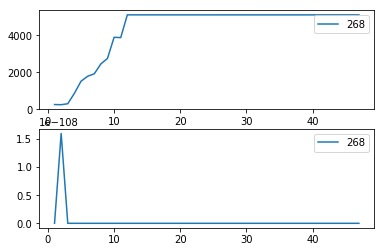

In [69]:
ax = plt.subplot(2,1,1)
aaf.predict_cumulative_hazard(harper).plot(ax=ax)

ax = plt.subplot(2,1,2)
aaf.predict_survival_function(harper).plot(ax=ax);

In [57]:
s = aaf.predict_survival_function(harper)
d_t = 1 - s
d_plus_t = d_t.shift(3)
h = (d_plus_t - d_t) / s

In [159]:
from lifelines import AalenAdditiveFitter, CoxPHFitter
from lifelines.datasets import load_regression_dataset
from lifelines.utils import k_fold_cross_validation

df = load_regression_dataset()

#create the three models we'd like to compare.
aaf_1 = AalenAdditiveFitter(coef_penalizer=0.5)
aaf_2 = AalenAdditiveFitter(coef_penalizer=10, fit_intercept=True)
cph = CoxPHFitter()

print(np.mean(k_fold_cross_validation(cph, df, duration_col='T', event_col='E')))
print(np.mean(k_fold_cross_validation(aaf_1, df, duration_col='T', event_col='E')))
print(np.mean(k_fold_cross_validation(aaf_2, df, duration_col='T', event_col='E')))

0.5678127754581945
 [-----------------100%-----------------] 152 of 152 complete in 0.2 sec
 [-----------------100%-----------------] 151 of 151 complete in 0.1 sec
 [-----------------100%-----------------] 151 of 151 complete in 0.1 sec
 [-----------------100%-----------------] 151 of 151 complete in 0.1 sec
 [-----------------100%-----------------] 151 of 151 complete in 0.1 sec
0.5726020282662642
 [-----------------100%-----------------] 152 of 152 complete in 0.1 sec
 [-----------------100%-----------------] 151 of 151 complete in 0.1 sec
 [-----------------100%-----------------] 151 of 151 complete in 0.1 sec
 [-----------------100%-----------------] 151 of 151 complete in 0.1 sec
 [-----------------100%-----------------] 151 of 151 complete in 0.1 sec
0.57374551716485


In [162]:
aaf_2.fit(df, duration_col='T', event_col='E')

 [-----------------100%-----------------] 189 of 189 complete in 0.2 sec


<lifelines.AalenAdditiveFitter: fitted with 200 observations, 11 censored>

In [169]:
survival_prob = aaf_2.predict_survival_function(df)[10]
dead_prob = 1 - survival_prob
hazerd = ((dead_prob.shift(-10) - dead_prob) / survival_prob)

/Users/taiyou/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['[IPAexGothic]'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


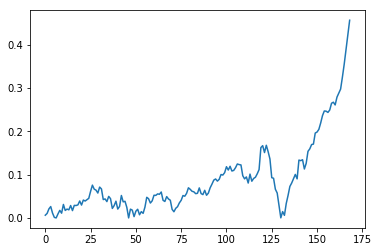

In [170]:
pd.Series(np.where(hazerd < 0, 0, hazerd)).plot()

In [175]:
df[['T', 'E']]

,T,E
0,14.785479,1
1,7.336734,1
2,5.271527,1
3,11.684168,1
4,7.637764,1
5,12.678268,1
6,6.601660,1
7,11.369137,1
8,14.680468,1
9,10.585059,1


In [174]:
aaf_2.predict_expectation(df)

,0
0,6.745883
1,9.357883
2,8.170616
3,7.979131
4,5.976536
5,10.079004
6,7.405604
7,5.694032
8,10.054064
9,8.076677


/Users/taiyou/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['[IPAexGothic]'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


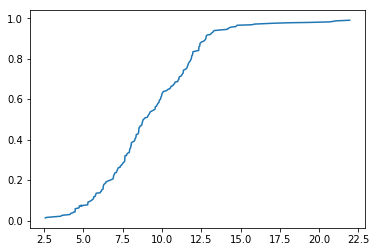

In [179]:
(1 - aaf_2.predict_survival_function(df[0:10]))[0].plot()